# Using Dask to process DAS data: "Seven Trees" Aftershock (10/25/2022) 
[//]: <> (Notebook Author: Thomas Cullison, Stanford University, Feb. 2023)


In this lab we will be using [Dask](https://docs.dask.org/en/stable/) to accelerate/parallelize the processing of distributed acoustic sensing (DAS) data. In particular, we will be processing data that was recorded during the aftershock of an earthquake that took place near the Seven Trees, CA area in October of 2022.  These data were recorded by a DAS interrogator that was connected to fiber-optic cables that traverse the area around the Stanford campus.


## External Resources
If you have any question regarding some specific Python functionality you can consult the official [Python documenation](http://docs.python.org/3/).

### Dask

* [Main Page](https://docs.dask.org/en/stable/)
* [General Tutorials \& Talks](https://docs.dask.org/en/stable/presentations.html)
* [Dask-Futures (more specific to this lab)](https://docs.dask.org/en/stable/futures.html)
* [Futures Tutorial](https://tutorial.dask.org/05_futures.html)
* [Github with Tutorial Jupyter Notebooks](https://github.com/dask/dask-tutorial)
* [High-level, but Extensive Overview Tutorial](https://youtu.be/EybGGLbLipI)


### DAS

* [Distributed Fiber-Optic Sensing](https://youtu.be/LAcQ44YRMuM): Overview of DAS and related technologies


## Required Preperation

Take a look at the API documentation for the following *dask.distributed* objects and functions.

* [Dask-Futures API](https://docs.dask.org/en/stable/futures.html#api)
* [Client](https://docs.dask.org/en/stable/futures.html#distributed.Client)
* [LocalCluster](https://distributed.dask.org/en/latest/api.html#distributed.LocalCluster)
* [Client.map()](https://docs.dask.org/en/stable/futures.html#distributed.Client.map)
* [wait()](https://docs.dask.org/en/stable/futures.html#distributed.wait)
* [Client.who_has()](https://docs.dask.org/en/stable/futures.html#distributed.Client.who_has)
* [Client.gather()](https://docs.dask.org/en/stable/futures.html#distributed.Client.gather)
* [Client.cancel()](https://docs.dask.org/en/stable/futures.html#distributed.Client.cancel)
* [Client.scatter()](https://docs.dask.org/en/stable/futures.html#distributed.Client.gather)

Also, please take a look at the following examples.

* [Dask-Futures Examples](https://examples.dask.org/futures.html)

<br><br>

## Exercise 0

Please answer the following questions below. (simple answers)

1. If one wishes to start a *Local Cluster*, what parameter, if any, needs to be passed to the *Client* constructor?

<br> The *Client* constructor takes a *LocalCluster* object as an argument (i.e. *Client(LocalCluster(n_workers=4))*), which creates a *LocalCluster* object with 4 workers. If no argument is passed to the *Client* constructor, then a *LocalCluster* object is created with default parameters. 

2. What is the difference between the following two *Cluster* parameters: *n_workers* and *threads_per_worker*?

<br> *n_workers* is the number of workers to start in the *Cluster*, and *threads_per_worker* is the number of threads per each worker.

3. How can one get a link to the *Dashboard* from a *Client*?

<br> The *Client* object has a *dashboard_link* attribute that can be used to get a link to the *Dashboard*. Or by default, when starting a scheduler on the local machine the dashboard will be served at http://localhost:8787/status, if the port 8787 is available.

4. How can a *LocalCluster* that is associated with a *Client* be rescaled?

<br> The *LocalCluster* object has a *scale()* method that can be used to rescale the number of workers in the *LocalCluster*.

5. What does the *Client.map()* function return?

<br> The *Client.map()* function returns a list, iterator, or Queue of  *Future* objects, depending on the type of the inputs.

6. What does the *wait()* function do?

<br> The *wait()* function waits for all futures to finish, and returns named tuple of completed, not completed.

7. What does the *Client.who_has()* function do?

<br> The *Client.who_has()* function returns the keys of the data that are held in each worker’s memory.

8. What does the *Client.gather()* function return, and where does the memory exist for the thing or things that are returned (e.g. in the memory of the worker(s), or in the memory of the "host-python-thread" (e.g. Jupyter-Notebook thread) that is interacting with the *Client* and *LocalCluster*)?

<br> The *Client.gather()* function returns a collection of the same type as the input, but now with
gathered results rather than futures from distributed memory. The memory for the results exists in the memory of the worker(s).

9. Can copies of the same memory exist both in the workers and on the "host-python-thread"?

<br> Yes. In Dask, data is divided into smaller chunks that are distributed across the workers. When performing operations on the data, Dask parallelizes the computation by dividing the task into smaller subtasks and distributing them across the worker. If the data is scattered to the workers, then the data will exist in the memory of the workers and on the "host-python-thread".

10. What function can be used to "clean-up/release" the memory held by a worker or workers?

<br> The *Client.cancel()* function can be used to cancel all tasks associated with a *Future* object, or a list of *Future* objects. This stops future from being scheduled if they have not yet run and deletes them if they have already run. After calling, this result and all dependent results will no longer be accessible

11. How can one rescale the number of workers in a cluster?

<br> The *Client.cluster* object has a *scale()* method that can be used to rescale the number of workers, e.g. *client.cluster.scale(4)*, with *client = Client()*.

12. How can data that is stored in the "host-python-thread" be distributed to workers in a *Cluster*/*LocalCluster*?

<br><br> The *Client.scatter()* function can be used to distribute data to workers in a *Cluster*/*LocalCluster*. The *Client.scatter()* function returns a list, iterator, or Queue of *Future* objects, depending on the type of the inputs.

## Exercise 1: Spin-up Dask-Cluster and Get Raw DAS Data

**Tasks for this exercise:**
* Import all the python modules that we need
* Define the functions we need to get the DAS data from the Cloud and to store the data into *numpy* arrays. 
* Spin-up a local dask-cluster
* Look at the *Dashboard* for the cluster
* Pull the data from the Cloud in parallel (one-worker per file)
* Collect the data to the "host-python-thread" that is running this notebook
* Clean-up data that resides in the workers
* Rescale the cluster
* Concatenate the gathered data along the time-axis to get it ready for parallel proccessing along the time time axis.

### Imports

In [48]:
import io

import datetime
import h5py
import numba

import numpy as np

from scipy import signal
from google.cloud import storage
from dask.distributed import Client, wait
from time import time
from os import cpu_count

### Function Defs for Getting Data from the Cloud

These have been defined for you because the knowledge of how to get these data is beyond the scope of this lab. However, it will probably be of some benefit to understand what these functions are doing.

In [49]:
def gcs_h5_to_buffer(bname,bucket=None):
    """ Pull data from Cloud storage (data is in hdf5 format) """
    client = storage.Client()
    bucket = client.get_bucket(bucket)
    blob = bucket.get_blob(bname)
    buffer = io.BytesIO()
    blob.download_to_file(buffer)
    
    return buffer


def h5_to_array(tbuffer):
    """ Get specific data from hdf5 and store to ndarrays """
    f = h5py.File(tbuffer, 'r')
    data = np.array(f["Acquisition"]["Raw[0]"]["RawData"],dtype=np.float32)
    tata = np.array(f["Acquisition"]["Raw[0]"]["RawDataTime"],dtype=np.dtype('<i8'))
    f.close()
    
    return data,tata


def read_h5_buffer_to_thing(func,bname,bucket=None):
    """ 
        Interface function for getting hdf5 data from
        the cloud and storing it into  different formats
    """
    buffer = gcs_h5_to_buffer(bname,bucket=bucket)
    item = func(buffer)
    del buffer
    return item
    
    
def read_h5_buffer_to_array(bname,bucket=None):
    """ Get ndarrays from the Cloud storage """
    return read_h5_buffer_to_thing(h5_to_array,bname,bucket=bucket)

### Setup List of Files to Read: (a priori Knowledge Req.)

Here we will generate a list of DAS data files that we need to process. Each file stores **one minute's** worth of data, and we will be getting **10** consecutive **minutes** of data for **48,000 channels**. The **channel spacing** is **one meter**. The **time-sampling**, $\mathbf \Delta t$, is **0.005 s**, and the aftershock occures within the 10 minute window that we are retrieving.

Knowing where this data is stored what files to get is beyond the scope of this lab, but the data is coming from the cloud, and at no point will it be stored to disk, which I think is pretty cool.

In [50]:
buckname = 'das-stanford' #kind of like the head/main directory
bdir = 'Stanford-P2kHz-GL20m-FS200Hz-1m-48000_2022-09-29T14_44_55-0700/'


lblob_e0 = ['Stanford-P2kHz-GL20m-FS200Hz-1m-48000_2022-10-25T183756Z.h5', \
            'Stanford-P2kHz-GL20m-FS200Hz-1m-48000_2022-10-25T183856Z.h5', \
            'Stanford-P2kHz-GL20m-FS200Hz-1m-48000_2022-10-25T183956Z.h5', \
            'Stanford-P2kHz-GL20m-FS200Hz-1m-48000_2022-10-25T184056Z.h5', \
            'Stanford-P2kHz-GL20m-FS200Hz-1m-48000_2022-10-25T184156Z.h5', \
            'Stanford-P2kHz-GL20m-FS200Hz-1m-48000_2022-10-25T184256Z.h5', \
            'Stanford-P2kHz-GL20m-FS200Hz-1m-48000_2022-10-25T184356Z.h5', \
            'Stanford-P2kHz-GL20m-FS200Hz-1m-48000_2022-10-25T184456Z.h5', \
            'Stanford-P2kHz-GL20m-FS200Hz-1m-48000_2022-10-25T184556Z.h5', \
            'Stanford-P2kHz-GL20m-FS200Hz-1m-48000_2022-10-25T184656Z.h5']

bloblist = [bdir+fname for fname in lblob_e0]
bucklist = [buckname for fname in lblob_e0]
nfiles = len(bloblist)
print(f'nfiles: {nfiles}')

nfiles: 10


### Start Dask Distributed Cluster: (10 Threads at Most, One-per-file, but Max of ncores)

In [51]:
ncore =  cpu_count() #use all the cores
#use a function call. See imports above
nwork = min(10,ncore) #use 10 workers or less than the number of cores

client = Client(n_workers=nwork,processes=True,threads_per_worker=1)
#Garbage collection problems if not set ----^   and --------------^

In [52]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 10,Total memory: 232.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37300,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 232.56 GiB
Comm: tcp://127.0.0.1:46367,Total threads: 1
Dashboard: http://127.0.0.1:35791/status,Memory: 23.26 GiB
Nanny: tcp://127.0.0.1:44166,


### Show the Dashboard link below

Then click the link. It should open another browser tab. Keep this tab open for the duration of this lab. Feel free to explore the *Dashboard*.  One thing of particular interest is the *CPU* tab in the bottom left quadrant.

In [53]:
# show the Dask dashboard
client.dashboard_link

'http://127.0.0.1:8787/status'

### Show the Memory for Each Worker in the Cluster

**Note of Caution:** when each worker has a "ton" of different memory chunks, this function can crash a notebook.  It is ok to use it for this exercise, but I *strongly* suggest that you don't use it after this exercise unless it has been explicityly requested to do so.

In [64]:
# show where the memory for each worker in the Cluster

# Get a dictionary of worker information, including memory usage
worker_info = client.scheduler_info()["workers"]

# Iterate over the workers and print their memory usage
for worker, info in worker_info.items():
    memory_used = info['metrics']['memory'] * 1e-9
    print(f"Worker {worker} is using {memory_used:.4f} GB of memory")

Worker tcp://127.0.0.1:32871 is using 0.0764 GB of memory
Worker tcp://127.0.0.1:33651 is using 0.0765 GB of memory
Worker tcp://127.0.0.1:35513 is using 0.0765 GB of memory
Worker tcp://127.0.0.1:36901 is using 0.0773 GB of memory
Worker tcp://127.0.0.1:37118 is using 0.0765 GB of memory
Worker tcp://127.0.0.1:38739 is using 0.0765 GB of memory
Worker tcp://127.0.0.1:40286 is using 0.0772 GB of memory
Worker tcp://127.0.0.1:42495 is using 0.0764 GB of memory
Worker tcp://127.0.0.1:44385 is using 0.0763 GB of memory
Worker tcp://127.0.0.1:46367 is using 0.0764 GB of memory


### Read All Files to Arrays -- Map to Threads : (Memory in Cluster)

Take notice of the output. This information can be useful when testing, debugging, or learning, but otherwise it mostly not useful. Read the comments!

**Watch** the *Dashboard* after executing the cell below

In [65]:
%%time

arrs = client.map(read_h5_buffer_to_array,bloblist,bucket=buckname,pure=False)
# Must set this flag to FALSE ---------------------------------------------^

# wait for the workers to finish above
wait(arrs)

CPU times: user 1.67 s, sys: 230 ms, total: 1.9 s
Wall time: 22.7 s


DoneAndNotDoneFutures(done={<Future: finished, type: tuple, key: read_h5_buffer_to_array-c9e320c4-1cd3-4b0a-8a0d-93baf0f7a044-8>, <Future: finished, type: tuple, key: read_h5_buffer_to_array-c9e320c4-1cd3-4b0a-8a0d-93baf0f7a044-2>, <Future: finished, type: tuple, key: read_h5_buffer_to_array-c9e320c4-1cd3-4b0a-8a0d-93baf0f7a044-5>, <Future: finished, type: tuple, key: read_h5_buffer_to_array-c9e320c4-1cd3-4b0a-8a0d-93baf0f7a044-9>, <Future: finished, type: tuple, key: read_h5_buffer_to_array-c9e320c4-1cd3-4b0a-8a0d-93baf0f7a044-0>, <Future: finished, type: tuple, key: read_h5_buffer_to_array-c9e320c4-1cd3-4b0a-8a0d-93baf0f7a044-6>, <Future: finished, type: tuple, key: read_h5_buffer_to_array-c9e320c4-1cd3-4b0a-8a0d-93baf0f7a044-4>, <Future: finished, type: tuple, key: read_h5_buffer_to_array-c9e320c4-1cd3-4b0a-8a0d-93baf0f7a044-7>, <Future: finished, type: tuple, key: read_h5_buffer_to_array-c9e320c4-1cd3-4b0a-8a0d-93baf0f7a044-1>, <Future: finished, type: tuple, key: read_h5_buffer_to

### Show the Memory for Each Worker

In [66]:
# show where the memory for each worker in the Cluster

# Get a dictionary of worker information, including memory usage
worker_info = client.scheduler_info()["workers"]

# Iterate over the workers and print their memory usage
for worker, info in worker_info.items():
    memory_used = info['metrics']['memory'] * 1e-9
    print(f"Worker {worker} is using {memory_used:.4f} GB of memory")

Worker tcp://127.0.0.1:32871 is using 2.4505 GB of memory
Worker tcp://127.0.0.1:33651 is using 2.4506 GB of memory
Worker tcp://127.0.0.1:35513 is using 2.4506 GB of memory
Worker tcp://127.0.0.1:36901 is using 2.4508 GB of memory
Worker tcp://127.0.0.1:37118 is using 2.4505 GB of memory
Worker tcp://127.0.0.1:38739 is using 2.4506 GB of memory
Worker tcp://127.0.0.1:40286 is using 2.4508 GB of memory
Worker tcp://127.0.0.1:42495 is using 2.4504 GB of memory
Worker tcp://127.0.0.1:44385 is using 2.4505 GB of memory
Worker tcp://127.0.0.1:46367 is using 2.4513 GB of memory


### Gather Arrays to Notebook

In [67]:
%%time

gathered_data = client.gather(arrs,direct=True)

CPU times: user 241 ms, sys: 14.1 s, total: 14.4 s
Wall time: 14.1 s


In [68]:
# show where the memory for each worker in the Cluster

# Get a dictionary of worker information, including memory usage
worker_info = client.scheduler_info()["workers"]

# Iterate over the workers and print their memory usage
for worker, info in worker_info.items():
    memory_used = info['metrics']['memory'] * 1e-9
    print(f"Worker {worker} is using {memory_used:.4f} GB of memory")

Worker tcp://127.0.0.1:32871 is using 2.4509 GB of memory
Worker tcp://127.0.0.1:33651 is using 2.4507 GB of memory
Worker tcp://127.0.0.1:35513 is using 2.4510 GB of memory
Worker tcp://127.0.0.1:36901 is using 2.4510 GB of memory
Worker tcp://127.0.0.1:37118 is using 2.4508 GB of memory
Worker tcp://127.0.0.1:38739 is using 2.4507 GB of memory
Worker tcp://127.0.0.1:40286 is using 2.4509 GB of memory
Worker tcp://127.0.0.1:42495 is using 2.4508 GB of memory
Worker tcp://127.0.0.1:44385 is using 2.4509 GB of memory
Worker tcp://127.0.0.1:46367 is using 2.4517 GB of memory


### Clean-up Cluster Memory

Be careful when using cleaning up memory from the workers. The data they store may have a dependency on other data that has yet to be processed. There may also be multiple variables that point to the same data before and after some processing has been applied to the data; therefore, one might accidentaly delete a dependency or unintentionally try to "double-delete/release" the same memory.

In [69]:
%%time

# clean up the workers first by cancelling the tasks and then shutting down
for t in arrs:
    client.cancel(t)
client.cancel(arrs)

CPU times: user 91.7 ms, sys: 7.27 ms, total: 99 ms
Wall time: 1.02 s


In [70]:
# show where the memory for each worker in the Cluster

# Get a dictionary of worker information, including memory usage
worker_info = client.scheduler_info()["workers"]

# Iterate over the workers and print their memory usage
for worker, info in worker_info.items():
    memory_used = info['metrics']['memory'] * 1e-9
    print(f"Worker {worker} is using {memory_used:.4f} GB of memory")

Worker tcp://127.0.0.1:32871 is using 0.1470 GB of memory
Worker tcp://127.0.0.1:33651 is using 0.1468 GB of memory
Worker tcp://127.0.0.1:35513 is using 0.1471 GB of memory
Worker tcp://127.0.0.1:36901 is using 0.1470 GB of memory
Worker tcp://127.0.0.1:37118 is using 0.1469 GB of memory
Worker tcp://127.0.0.1:38739 is using 0.1468 GB of memory
Worker tcp://127.0.0.1:40286 is using 0.1470 GB of memory
Worker tcp://127.0.0.1:42495 is using 0.1469 GB of memory
Worker tcp://127.0.0.1:44385 is using 0.1469 GB of memory
Worker tcp://127.0.0.1:46367 is using 0.1477 GB of memory


### Scale-down Cluster to One Worker

Take a look at the *Dashboard* after you do this, especially the *CPU* tab.

In [71]:
%%time

# scale to only one worker
client.cluster.scale(1)

CPU times: user 298 µs, sys: 0 ns, total: 298 µs
Wall time: 262 µs


### Concatenate Arrays Over Time Axis: (Notebook Thread)

This part has been done for you, but be sure you understand what is happening.

In [72]:
%%time

# convert the list of tuples (two elements) to two separate lists
tup_list = list(map(list, zip(*gathered_data)))
rdlist = tup_list[0]
rtlist = tup_list[1]

CPU times: user 11 µs, sys: 3 µs, total: 14 µs
Wall time: 18.8 µs


In [73]:
%%time

# np.hstack() should also work
rdata = np.concatenate(rdlist,axis=1)
tdata = np.concatenate(rtlist)

# The deletes below are for the "host-python-thread" (this notebook), only, 
# not the workers in the cluster
del rdlist[:]
del rdlist
del rtlist[:]
del rtlist

CPU times: user 4.34 s, sys: 8.01 s, total: 12.4 s
Wall time: 12 s


## Show the Shape of the Concatenated Array

Is it what you expect? if not, you may have to fix something above.

In [74]:
#show the shape of the concatenated array as a Q.C. (your code)
print("rdata.shape: ",rdata.shape)
print("tdata.shape: ",tdata.shape)

rdata.shape:  (48000, 120000)
tdata.shape:  (120000,)


<br>

## Exercise 2

Now that we have collected the data and concatenated it along the time axis, we can preprocess the data so that we can may analyze it. Most of the preprocessign will be done by the workers in our local dask-cluster. However, the last preprocessing step will be done in parallel, using numba, by the "host-python-thread." This last processing step accessed the data at a single-point-in-time but across all channels. Think about why this might be a good idea.

**Tasks for this exercise:**
* Plot the raw-data via the "host-python-thread", so that we can eventually compare with the final preprocessed result.
* Define our functions we will used for preproccing.
* Scale-up the cluster so that there are as many workers as there are cores
* Scatter our concatenated, raw-data, array from the "host-python-thread" to the workers (splitting-up along the channel axis, not the time-axis).
* Run our preprocessing functions for each channel
* Gather the data back to the "host-python-thread" for the last preprocessing step.
* Shutdown the local dask-cluster
* Run the last preprocessing function
* Plot the final results of the preprocessing.

<br>

### Define function for plotting: (host-python-thread only)

**Note:** This function has been defined for you. Furthermore, we will only be plotting a subrange of channels because, given the limited screen space of the notebook, it is somewhat cummbersome to look at all 48k channels at once. See the code lines for *start_c* and *end_c*, below.

In [75]:
def plot_seven_trees_data(data,times,pclip=.95,fig_size=(9,10)):

    import matplotlib.pyplot as plt

    eqdate = datetime.datetime.utcfromtimestamp(times[0]//1000000)
    start_c = 23000
    end_c = 35000 
    bounds = (0,nfiles*60,end_c,start_c)


    vclip = (1-pclip)*np.abs(data[start_c:end_c+1,:]).max()


    plt.figure(figsize=fig_size)
    plt.imshow(data[start_c:end_c+1,:], aspect='auto', interpolation='none', cmap='gray', vmin=-vclip, vmax=vclip, extent=bounds)
    plt.title('DAS for Seven Trees 1st-Aftershock, 3.1 EQ @' + str(eqdate) )
    plt.xlabel('seconds from: ' + str(eqdate.time()))
    plt.ylabel('channel')
    
    return plt

### 2D Plot of the Raw DAS Data

This part has been done for you. It will take a while...

pclip: 0.1


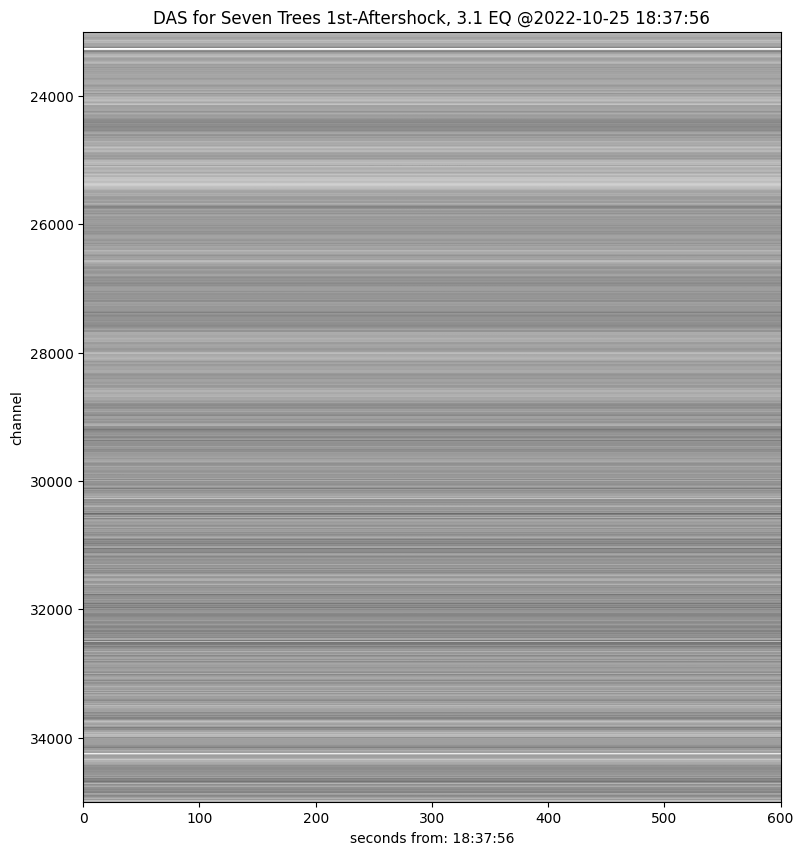

CPU times: user 13.2 s, sys: 14.2 s, total: 27.3 s
Wall time: 26.4 s


In [79]:
%%time

# We will use a different clip after preprocessing because
# the dynamic range will be so different
pclip = 0.1 
print(f'pclip: {pclip}')

plt = plot_seven_trees_data(rdata,tdata,pclip=pclip)
plt.show()

<br>

### Doesn't the plot above look magnificent!?
[//]: <> (as magnificent as Trogdor? https://youtu.be/90X5NJleYJQ)

Run the cell below to clean up the memory related to the plot. It can help with making the notebook run more "smoothly."

In [80]:
# Clean the gunk
plt.close('all')
del plt

### Function Defs for Processing

In [81]:
# Notice that this function will be ran on the "host-python-thread"
@numba.njit(cache=True, fastmath=True, nogil=True, parallel=True)
def remove_median_xchannel(orig_tr):
    """ remove the median cross-channel value for every time sample"""
    rmed_traces = orig_tr.copy()
    for it in numba.prange(orig_tr.shape[-1]):
        rmed_traces[:, it] -= np.median(orig_tr[:, it])
    return rmed_traces


def detrend_single_trace(orig_tr):
    """ 
        Remove the mean and any linear trend in the data along 
        the time-axis. Runs on the workers.
        (operates per channel)
    """
    det_const = signal.detrend(orig_tr,type='constant')
    det_trace = signal.detrend(det_const,type='linear')
    del det_const
    return det_trace


def bandpass_butter_single_trace(trace, fs=None, b0=None, bN=None, order=5):
    """ 
        Band pass the data along the time-axis. Runs on the workers.
        (operates per channel)
    """
    sos = signal.butter(order, (b0,bN), 'bandpass', fs=fs, output='sos')
    bp_trace = signal.sosfiltfilt(sos, trace)
    return bp_trace


def silly_decimate_single_trace(orig_tr,q=2):
    """
        Decimate the data after bandpassing. Runs on the Workers. 
        (operates per channel)
    """
    return orig_tr[::q]

### Scale-up Cluster to All Cores for Data Processing

Look at the *CPU* tab in the *Dashboard* after launching the cell below.

In [82]:
%%time

# scale to all available workers for data processing
nwork = min(10,ncore) #use 10 workers or less than the number of cores
client.cluster.scale(nwork)

CPU times: user 119 µs, sys: 0 ns, total: 119 µs
Wall time: 120 µs


### Scatter Concatenated, Raw Data to All Workers (from Notebook to Cluster)

Read the comments!
<br>
**Watch** the *Dashboard* as soon as you execute the cell below.
<br>
**Do NOT** try to display the memory across all the workers. It will likely crash and mangle your notebook.

In [83]:
%%time

# scatter the data concatenated array to the workers
future = client.scatter(list(rdata))

# wait for the workers to finish above
junk = wait(future)

CPU times: user 36.4 s, sys: 24 s, total: 1min
Wall time: 59.7 s


### Detrend Data Per Channel: Multiple Channels Per Worker

The scheduler decides based on how the data was scattered above.
<br>
**Watch** the *Dashboard* as soon as you execute the cell below.

In [84]:
%%time

# detrend the data per channel: multiple channels per worker
det_data = client.map(detrend_single_trace,future,pure=False)
junk = wait(det_data)

rdata_dtype = rdata.dtype #save for gathering
del rdata #clean-up Notebook Memory

CPU times: user 36.1 s, sys: 3.69 s, total: 39.7 s
Wall time: 50.8 s


### Bandpass Filter Per Channel (Nearly the same as for Detrend)

**Watch** the *Dashboard*

In [85]:
%%time

bl = 0.025
br = 5.0
fs = 200

# bandpass the data per channel
bp_data = client.map(bandpass_butter_single_trace,det_data,fs=fs,b0=bl,bN=br,pure=False)

junk = wait(bp_data)

CPU times: user 1min 10s, sys: 2.6 s, total: 1min 13s
Wall time: 1min 21s


### Decimate Per Channel

This is slightly faster than if the decimation where done by the "host-python-thread" after gathering.
<br>
**Watch** the *Dashboard*

In [86]:
%%time 

ss = 4 #decimation factor -- same as parameter 'q=' in the function

# Decimate the data per channel
dec_data = client.map(silly_decimate_single_trace,bp_data,q=ss,pure=False)

junk = wait(dec_data)


CPU times: user 31.7 s, sys: 1 s, total: 32.7 s
Wall time: 31.9 s


### Gather Preprocessed Data: (From cluster to Notebook)

It's pretty boring to watch the *Dashboard* for this step.

In [87]:
%%time

# gather the data back to the host-python-thread
dec_bp_data = np.asarray(client.gather(dec_data,direct=True),dtype=rdata_dtype)
#                          ^                       #NOTE: ------------^
#                          |
# --- LOOK ----------------  # for some reason this is slightly faster than two lines of code


# NOTE: np.vstack() has ~same RUNTIME as np.asarray()

CPU times: user 7.24 s, sys: 8.77 s, total: 16 s
Wall time: 17 s


## Show the Shape of the Processed Array

Is it what you expect? if not, you may have to fix something above. Reminder: you have decimated the array along the time-axis.

In [88]:
#show the shape of the processed array as a Q.C. (your code)
print("dec_bp_data.shape: ",dec_bp_data.shape)


dec_bp_data.shape:  (48000, 30000)


### Release Cluster and Scheduler: (and All Related Resources, i.e. Memory, Cores, etc.)

This part has been done for you.
<br>
Look at the *Dashboard* **after** you run the cell below.

In [89]:
%%time
client.shutdown()
client.close()

CPU times: user 17.5 s, sys: 153 ms, total: 17.7 s
Wall time: 17.7 s


### X-Channel Median Removal Per Time-Sample

This part has been done for you, and it happens on the "host-python-thread." It will be quite fast compared to the other processing steps. Ponder as to why this is so much faster, and tell me your thoughts on this in the *markdown* cell that follows the code.

In [90]:
%%time

# X-channel median removal
proc_data = remove_median_xchannel(dec_bp_data)

del dec_bp_data # clean up notebook memory

CPU times: user 2min 10s, sys: 2.77 s, total: 2min 13s
Wall time: 8.98 s


<br>

### Provide your thoughts on the X-Channel Parallel Speed-up over the Dask-Cluster Processing Steps

"The X-Channel function is optimized using Numba to speed up processing, whereas the Dask-Cluster Processing Steps approach involves distributing the processing across multiple machines or nodes in a cluster. Since the X-Channel function is used on the decimate array (the size has been reduced), the speed using numba can be faster that the Dask version. On one hand, the overhead to distribute the array is avoided. On the other hand, the numba.prange can speed up the operation using multithreading."
<br><br>

### 2D Plot of the Processed DAS Data (Yay! Finally)

This part has been done for you.

pclip: 0.99


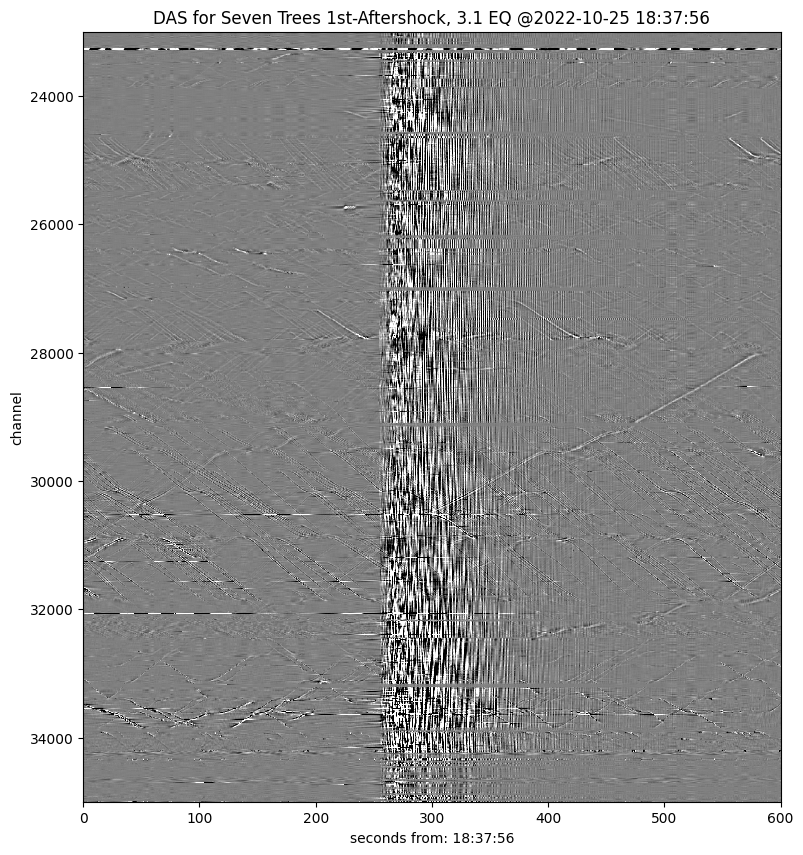

CPU times: user 3.69 s, sys: 3.97 s, total: 7.66 s
Wall time: 7.37 s


In [91]:
%%time

pclip = .99
print(f'pclip: {pclip}')

plt = plot_seven_trees_data(proc_data,tdata[::ss],pclip=pclip)
plt.show()

<br>

### Roughly how many seconds into the data does the aftershock arrive?

"I learned that the main shock occurred at 2022-10-22 11:42 (GMT -7). But from the original time in the figure above, the aftershock arrives at around 260 * 0.005 * 4 = 5.2s."

<br>